In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns






#### Load data

In [9]:

tc_streamRECORDS_PATH = "../data/sarze_4/output/joined_fp_long_second.csv"  # 45 000 rows


# ---------- 1.  Read the two files ----------
df_tc_stream  = pd.read_csv(tc_streamRECORDS_PATH,        # 45 000 rows
                    parse_dates=["time"])               # column name is 'time'


#data loading
df_meteo_temp = pd.read_csv(r"..\data\sarze_4\teplota\gw1100a_outdoor_temperature.csv",  # outdoor sensor
                    parse_dates=["time"],index_col=False)

only_part = False


if only_part:

    start_date = '2025-04-13'
    end_date = '2025-04-15'


    df_meteo_temp = df_meteo_temp[(df_meteo_temp['time'] >= start_date) & (df_meteo_temp['time'] <= end_date)].copy()
    df_meteo_temp = df_meteo_temp.reset_index(drop=True)  
    
    df_tc_stream =  pd.read_csv(tc_streamRECORDS_PATH,       
                    parse_dates=["time"])   


<Axes: xlabel='time'>

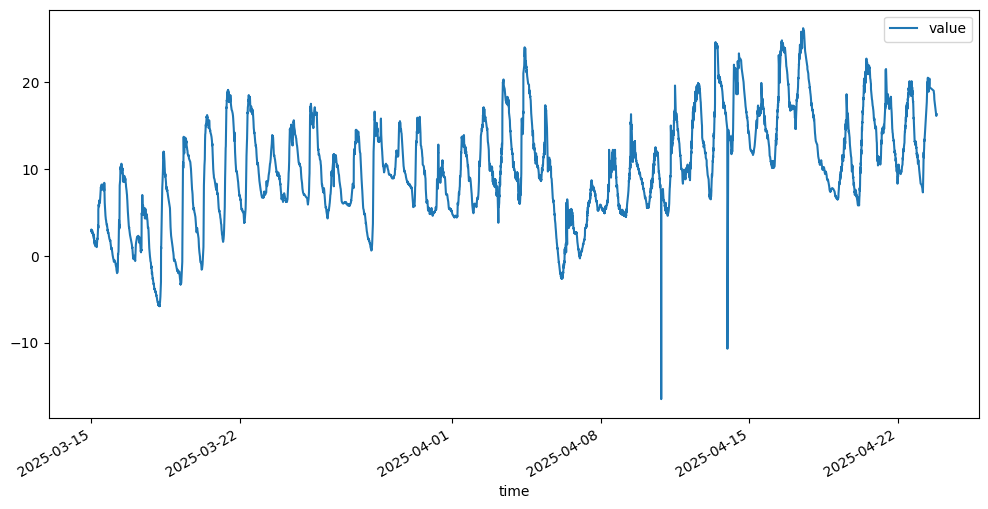

In [10]:



#df.plot(x='time', y='value')          # quick sanity check
df_meteo_temp.plot(y='value', x='time', figsize=(12, 6))  # quick sanity check




In [11]:
print(df_meteo_temp["value"].unique())
print(df_meteo_temp.head(10))
fil_sort_df = df_meteo_temp.sort_values(by='time')
print(fil_sort_df.head(10))

[  3.    2.9   2.8   2.7   2.6   2.5   2.4   2.3   2.2   2.1   2.    1.9
   1.8   1.7   1.6   1.5   1.4   1.3   1.2   1.1   1.    3.1   3.2   3.3
   3.5   3.4   5.3   5.5   5.7   5.9   5.8   6.1   6.2   6.4   6.3   7.2
   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.4   7.
   6.9   6.8   6.6   6.5   6.    5.6   5.4   5.2   5.1   5.    4.9   4.8
   4.7   4.6   4.5   4.4   4.3   4.2   4.1   4.    3.9   3.8   3.7   3.6
   0.9   0.8   0.7   0.6   0.4   0.2   0.1   0.   -0.2  -0.3  -0.4  -0.5
  -0.6  -0.7  -0.8  -0.9  -1.   -1.1  -1.2  -1.3  -1.4  -1.6  -1.8  -1.9
  -2.   -1.7   0.5   8.7   8.9   9.1   9.5  10.   10.1  10.3  10.2   9.7
   9.6   9.9   9.8  10.5  10.6  10.4   9.4   9.2   8.8   8.6   8.5   9.
   8.3   6.7  -0.1  -2.1  -2.6  -2.7  -2.8  -2.9  -3.   -3.1  -3.2  -3.3
  -3.4  -3.5  -3.6  -3.7  -3.8  -3.9  -4.   -4.1  -4.2  -4.3  -4.4  -4.5
  -4.6  -4.7  -4.8  -4.9  -5.   -5.1  -5.2  -5.3  -5.4  -5.5  -5.6  -5.7
  -5.8  10.8  11.   11.2  11.4  11.5  11.8  11.9  11.

Imporvizace při čištění dat s MAD; místo medianu využitít mean lépe zvládá stoupající a klesající křivky 

300    0.27152
301    0.27088
302    0.26896
303    0.26688
304    0.26512
Name: value, dtype: float64
300     9.980
301     9.996
302    10.020
303    10.036
304    10.044
Name: value, dtype: float64
[0.09938556 0.09857231 0.09360082 ... 0.9336661  0.9534994  0.96253781]
outliers detected 16


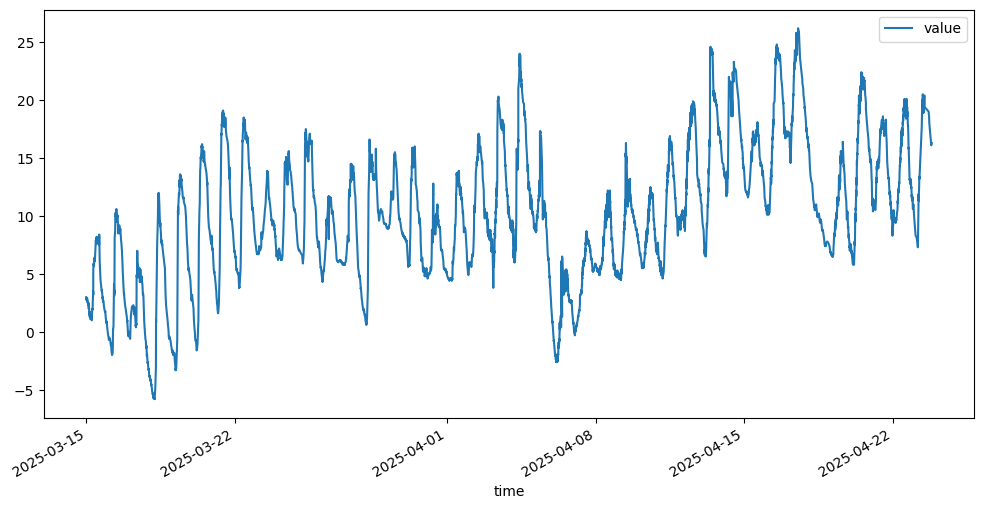

In [12]:
k = 25                               # 25-sample window
rolling_med = df_meteo_temp['value'].rolling(k, center=True, min_periods=5).mean()
mad = (df_meteo_temp['value'] - rolling_med).abs().rolling(k, center=True, min_periods=5).mean()
print(mad[300:305])
print(rolling_med[300:305])
print(mad.unique())
threshold = 3 * 1.4826 * mad         # 3 × MAD ~ 3 σ for normal data
valid = rolling_med.notna() & mad.notna()
mask = ((df_meteo_temp['value'] - rolling_med).abs() < threshold) & valid
clean = df_meteo_temp[mask]
clean.plot(y='value', x='time', figsize=(12, 6))  # quick sanity check

clean_meteo_temp =  clean.copy()



print("outliers detected", len(df_meteo_temp) -len(clean))

### Joine the tables

In [13]:
df_tc = df_tc_stream[~df_tc_stream['time'].duplicated(keep=False)] 
df_meteo = df_meteo_temp[~df_meteo_temp['time'].duplicated(keep=False)] 

print("num of duplicated values in main stream", len(df_tc)-len(df_tc_stream))
print("num of duplicated values in temperatures from meteo station nearby", len(df_meteo)-len(df_meteo_temp))

num of duplicated values in main stream -2
num of duplicated values in temperatures from meteo station nearby 0


In [14]:



df_tc_stream  = df_tc_stream.sort_values("time")
df_meteo_temp = clean_meteo_temp.sort_values("time")


out = pd.merge_asof(
        df_tc_stream, df_meteo_temp,
        on="time",
        direction="nearest",
        tolerance=pd.Timedelta("20 min")   
      )


out = out.rename(columns={"value": "outdoor_temperature"})

out["seconds_delta"] = (out["time"] - out["time"].shift()).dt.total_seconds()


out.to_csv("joined_with_outdoor_temp.csv", index=False)


///: todo weighted average

In [15]:
gap = pd.Timedelta('30min')

temp_bwd = (
    pd.merge_asof(
        out[out['outdoor_temperature'].isna()][['time']],   
        df_meteo_temp.sort_values('time'),
        on='time',
        direction='backward',
        tolerance=gap
    )
    .rename(columns={'value': 'temp_bwd'})
)

temp_fwd = (
    pd.merge_asof(
        out[out['outdoor_temperature'].isna()][['time']],   
        df_meteo_temp.sort_values('time'),
        on='time',
        direction='forward',
        tolerance=gap
    )
    .rename(columns={'value': 'temp_fwd'})



tmp = temp_bwd.merge(temp_fwd, on='time', how='outer')


tmp['imputed'] = tmp[['temp_bwd', 'temp_fwd']].mean(axis=1)
tmp['imputed'] = tmp['imputed'].where(tmp[['temp_bwd', 'temp_fwd']].notna().all(axis=1))

# ------------------------------------------------------------------
# 4.  Push the imputed values back into `out`
# ------------------------------------------------------------------
out = out.merge(tmp[['time', 'imputed']], on='time', how='left')
need_impute = out['outdoor_temperature'].isna() & out['imputed'].notna()
out.loc[need_impute, 'outdoor_temperature'] = out.loc[need_impute, 'imputed']

# (Optional) drop the helper column
out = out.drop(columns='imputed')

In [16]:
# Count the number of records in 'out' where 'outdoor_temperature' is NAN
nan_count = out['outdoor_temperature'].isna().sum()
print("Number of records with NAN in outdoor_temperature:", nan_count)


print("percentage of rows with NAN value : ", nan_count /len(out) *100 )

Number of records with NAN in outdoor_temperature: 725
percentage of rows with NAN value :  1.596564633340674


In [17]:
data_f_model = out.dropna(subset=['outdoor_temperature'])


In [18]:
print(out.head())

                 time  temperature  prikon_tc0  prikon_tc1  prikon_tc2  \
0 2025-03-15 00:00:16          2.8         0.0       500.0       500.0   
1 2025-03-15 00:02:46          2.6         0.0       500.0       500.0   
2 2025-03-15 00:05:31          2.8         0.0       500.0       500.0   
3 2025-03-15 00:07:46          2.6         0.0       500.0       500.0   
4 2025-03-15 00:09:01          2.5         0.0       500.0       500.0   

   prikon_tc3  fanh_tc0  fanh_tc1  fanh_tc2  fanh_tc3  outdoor_temperature  \
0         0.0  2.409091  2.713793  2.857895       0.0                  3.0   
1         0.0  2.409091  2.713793  2.857895       0.0                  3.0   
2         0.0  2.409091  2.730000  2.857895       0.0                  3.0   
3         0.0  2.409091  2.713793  2.857895       0.0                  3.0   
4         0.0  2.409091  2.713793  2.857895       0.0                  3.0   

   seconds_delta  
0            NaN  
1          150.0  
2          165.0  
3         

### ***COMPUTE LABEL*** computing difference between actual temperature and the the said by TC

In [19]:
data_f_model["temperature_delta"] = data_f_model["outdoor_temperature"] - data_f_model["temperature"]

print(data_f_model.head())


data_w_label = data_f_model.drop(columns=["outdoor_temperature","seconds_delta"])


#renaming columns bacause of mistake in schema
data_w_label.columns = [
    "time",
    "temperature",
    "fanh_tc0",
    "fanh_tc1",
    "fanh_tc2",
    "fanh_tc3",
    "prikon_tc0",
    "prikon_tc1",
    "prikon_tc2",
    "prikon_tc3",
    "temperature_delta"
]

print(data_w_label.head())

df = data_w_label.copy()

                 time  temperature  prikon_tc0  prikon_tc1  prikon_tc2  \
0 2025-03-15 00:00:16          2.8         0.0       500.0       500.0   
1 2025-03-15 00:02:46          2.6         0.0       500.0       500.0   
2 2025-03-15 00:05:31          2.8         0.0       500.0       500.0   
3 2025-03-15 00:07:46          2.6         0.0       500.0       500.0   
4 2025-03-15 00:09:01          2.5         0.0       500.0       500.0   

   prikon_tc3  fanh_tc0  fanh_tc1  fanh_tc2  fanh_tc3  outdoor_temperature  \
0         0.0  2.409091  2.713793  2.857895       0.0                  3.0   
1         0.0  2.409091  2.713793  2.857895       0.0                  3.0   
2         0.0  2.409091  2.730000  2.857895       0.0                  3.0   
3         0.0  2.409091  2.713793  2.857895       0.0                  3.0   
4         0.0  2.409091  2.713793  2.857895       0.0                  3.0   

   seconds_delta  temperature_delta  
0            NaN                0.2  
1         

C:\Users\patri\AppData\Local\Temp\ipykernel_17588\3971670982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f_model["temperature_delta"] = data_f_model["outdoor_temperature"] - data_f_model["temperature"]


## MODELING

In [20]:
print(abs(data_f_model["temperature_delta"]).describe())


count    44685.000000
mean         0.862724
std          2.382090
min        -12.700000
25%         -0.200001
50%          0.800000
75%          2.000000
max          9.400000
Name: temperature_delta, dtype: float64


### XGBRegressor

#### Feature-engineering

-- already done this in pyflink 
nevím nakolik bych mohl dělat tady, rpotože 

'NUMERIC_COLS = [\n    "temperature",\n    "fanh_tc0", "fanh_tc1", "fanh_tc2", "fanh_tc3",\n    "prikon_tc0", "prikon_tc1", "prikon_tc2", "prikon_tc3",\n]\n\nTARGET = "temperature_delta"\nLAG_STEPS = [1, 2, 3]           # past 3 observations\nROLL_WINDOWS = [3, 6]           # past 3 / 6 rows mean\n\n# create lag features\nfor col in NUMERIC_COLS:\n    for lag in LAG_STEPS:\n        df[f"{col}_lag{lag}"] = df[col].shift(lag)      # pandas shift for lags :contentReference[oaicite:5]{index=5}\n    for win in ROLL_WINDOWS:\n        df[f"{col}_roll{win}_mean"] = df[col].shift(1).rolling(win).mean()\n\n# drop rows with NaNs introduced by shifting\ndf = df.dropna().reset_index(drop=True)\n'

In [22]:
# libraries
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import dump, load                      # fast, numpy-aware persistence :contentReference[oaicite:0]{index=0}

from sklearn.metrics import mean_absolute_error    # MAE for regression :contentReference[oaicite:1]{index=1}
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV  # CV that respects order :contentReference[oaicite:2]{index=2}
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor 


In [25]:
NUMERIC_COLS = [
    "temperature",
    "fanh_tc0", "fanh_tc1", "fanh_tc2", "fanh_tc3",
    "prikon_tc0", "prikon_tc1", "prikon_tc2", "prikon_tc3",
]

TARGET = "temperature_delta"

# hold-out the newest 20 % for final test
test_size = int(len(df) * 0.20)
train_df, test_df = df.iloc[:-test_size], df.iloc[-test_size:]

X_train, y_train = train_df.drop(columns=[TARGET, "time"]), train_df[TARGET]
X_test,  y_test  = test_df.drop(columns=[TARGET, "time"]),  test_df[TARGET]

# numeric scaling (optional for XGBoost but helps if you try linear models later)
preproc = ColumnTransformer(
    [("scale", StandardScaler(), X_train.columns)],
    remainder="passthrough"
)                                                       

# base regressor with fast histogram grow policy
xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",          # CPU-fast; use "gpu_hist" if GPU
    eval_metric="RMSA",
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

pipe = Pipeline([
    ("prep", preproc),
    ("model", xgb)
])

# hyperparameter grid (very small demo grid; expand as needed)
param_grid = {
    "model__n_estimators": [400, 800],
    "model__max_depth":   [4, 6, 8],
    "model__min_child_weight": [1, 5],
}

tscv = TimeSeriesSplit(n_splits=5)                       

gcv = GridSearchCV(
    pipe,
    param_grid,
    cv=tscv,
    scoring="neg_root_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
)

gcv.fit(X_train, y_train, 
        model__verbose=False)       


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         Index(['temperature', 'fanh_tc0', 'fanh_tc1', 'fanh_tc2', 'fanh_tc3',
       'prikon_tc0', 'prikon_tc1', 'prikon_tc2', 'prikon_tc3'],
      dtype='object'))])),
                                       ('model',
                                        XG...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [4, 6, 8],
                         'model__min_child_weight': [1, 5],
                         'model__n_estimators': [400, 800]},
             scoring='neg_mean_absolute_error', verbose=2)

In [26]:
best_model = gcv.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test  MAE: {mae:.4f}")

Test  MAE: 2.1906


In [27]:
Path("models").mkdir(exist_ok=True)
dump(best_model, "models/deltaT_xgb.joblib")  

['models/deltaT_xgb.joblib']